In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification


In [13]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
FILE_PATH = "PlantVillage"


In [14]:
!mkdir "PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Pepper__bell___healthy/" "/kaggle/working/PlantVillage"

mkdir: cannot create directory 'PlantVillage': File exists


In [15]:

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(FILE_PATH, transform=transform)

In [16]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [21]:
model.classifier = nn.Linear(model.config.hidden_size, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
criterion = nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

Using device: cuda


In [22]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = total_loss / len(train_loader)

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch + 1}/{EPOCHS}, '
          f'Training Loss: {avg_loss:.4f}, '
          f'Training Accuracy: {accuracy:.4f}')

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/10, Training Loss: 0.1139, Training Accuracy: 0.9520
Test Accuracy: 0.9960
Epoch 2/10, Training Loss: 0.0088, Training Accuracy: 0.9975
Test Accuracy: 1.0000
Epoch 3/10, Training Loss: 0.0047, Training Accuracy: 0.9990
Test Accuracy: 0.9939
Epoch 4/10, Training Loss: 0.0023, Training Accuracy: 0.9990
Test Accuracy: 0.9980
Epoch 5/10, Training Loss: 0.0007, Training Accuracy: 1.0000
Test Accuracy: 0.9980
Epoch 6/10, Training Loss: 0.0005, Training Accuracy: 1.0000
Test Accuracy: 0.9980
Epoch 7/10, Training Loss: 0.0004, Training Accuracy: 1.0000
Test Accuracy: 0.9980
Epoch 8/10, Training Loss: 0.0003, Training Accuracy: 1.0000
Test Accuracy: 0.9960
Epoch 9/10, Training Loss: 0.0002, Training Accuracy: 1.0000
Test Accuracy: 0.9980
Epoch 10/10, Training Loss: 0.0002, Training Accuracy: 1.0000
Test Accuracy: 1.0000


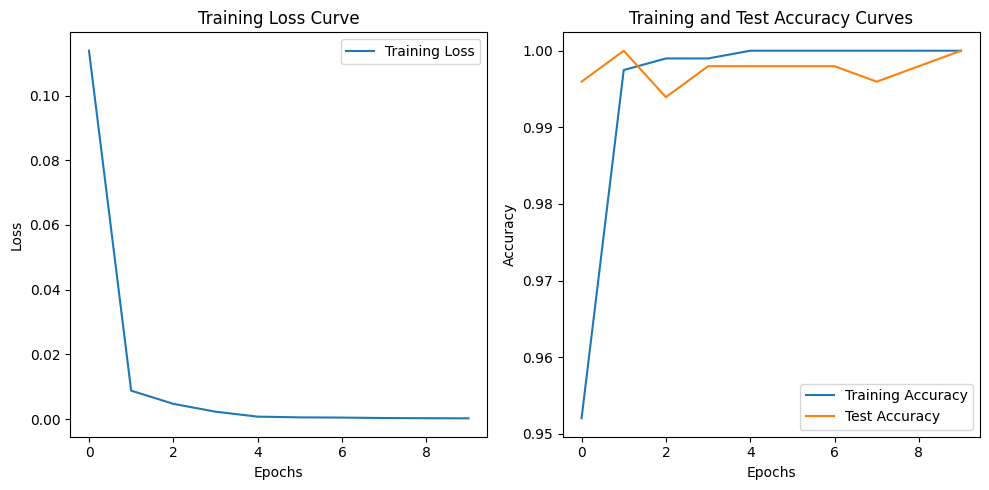

In [23]:
import matplotlib.pyplot as plt
# Plotting the curves
plt.figure(figsize=(10, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Assuming your model is named 'model'
# torch.save(model.state_dict(), 'model_weights.h5')
torch.save(model.state_dict(), '/kaggle/working/plant_disease_model.pth')

